# 基于MindSpore实现目标分割

本实验介绍利用MindSpore框架，使用Unet网络实现图像分割。

## 1、实验目的

(1)了解Unet架构。

(2)掌握如何使用MindSpore进行简单图像分割任务的训练和预测。

## 2、Unet模型原理介绍

### 2.1 模型简介

Unet模型于2015年在论文《U-Net: Convolutional Networks for Biomedical Image Segmentation》中被提出，最初的提出是为了解决医学图像分割问题，用于细胞层面的图像分割任务。

Unet模型是在FCN网络的基础上构建的，但由于FCN无法获取上下文信息以及位置信息，导致准确性较低，Unet模型由此引入了U型结构获取上述两种信息，并且模型结构简单高效、容易构建，在较小的数据集上也能实现较高的准确率。

### 2.2 模型结构
Unet模型的整体结构由两部分组成，即特征提取网络和特征融合网络，其结构也被称为“编码器-解码器结构”，并且由于网络整体结构类似于大写的英文字母“U”，故得名Unet，在其原始论文中定义的网络结构下图所示。

![Unet模型.png](./Unet模型.png)

整个模型结构就是在原始图像输入后，首先进行特征提取，再进行特征融合：

a) 左半部分负责特征提取的网络结构（即编码器结构）需要利用两个3x3的卷积核与2x2的池化层组成一个“下采样模块”，每一个下采样模块首先会对特征图进行两次valid卷积，再进行一次池化操作。由此经过4个下采样模块后，原始尺寸为572x572大小、通道数为1的原始图像，转换为了大小为28x28、通道数为1024的特征图。

b) 右半部分负责进行上采样的网络结构（即解码器结构）需要利用1次反卷积操作、特征拼接操作以及两个3x3的卷积核作为一个“上采样模块”，每一个上采样模块首先会对特征图通过反卷积操作使图像尺寸增加1倍，再通过拼接编码器结构中的特征图使得通道数增加，最后经过两次valid卷积。由此经过4个上采样模块后，经过下采样模块的、大小为28x28、通道数为1024的特征图，转换为了大小为388x388、通道数为64的特征图。

c) 网络结构的最后一部分是通过两个1x1的卷积核将经过上采样得到的通道数为64的特征图，转换为了通道数为2的图像作为预测结果输出。
### 2.3 模型特点

a) 利用拼接操作将低级特征图与高级特征图进行特征融合

b) 完全对称的U型结构使得高分辨率信息和低分辨率信息在目标图片中增加，前后特征融合更为彻底。

c) 结合了下采样时的低分辨率信息（提供物体类别识别依据）和上采样时的高分辨率信息（提供精准分割定位依据），此外还通过融合操作填补底层信息以提高分割精度。



## 3、实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、数据处理
### 4.1数据准备
案例实现所使用的数据即ISBI果蝇电镜图数据集，可以从http://brainiac2.mit.edu/isbi_challenge/ 中下载，下载好的数据集包括3个tif文件，分别对应测试集样本、训练集标签、训练集样本，文件路径结构如下：

```
.ISBI/
    ├── test-volume.tif
    ├── train-labels.tif
    └── train-volume.tif
```

其中每个tif文件都由30张图片压缩而成，所以接下来需要得到训练集样本对应的30张png图片、训练集标签对应的30张png图片以及测试集样本对应的30张png图片。

In [1]:
import os
import mindspore
from mindspore import context
device_id = int(0)
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
mindspore.set_seed(1)

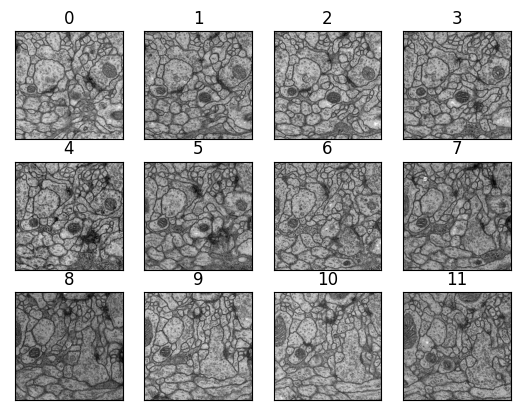

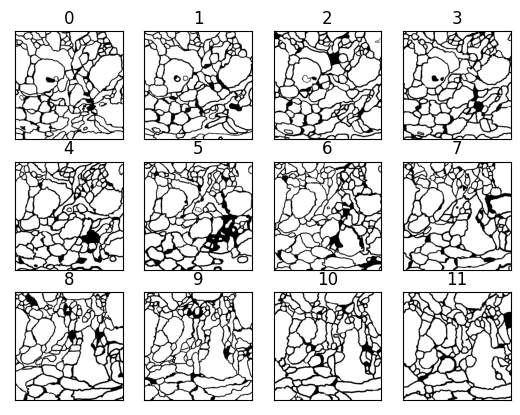

In [2]:
import math
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

#显示下载好的数据
train_image_path = "data/train-volume.tif"
train_masks_path = "data/train-labels.tif"
image = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_image_path))])
masks = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_masks_path))])

#展示图片
def show_image(image_list,num = 6):
    img_titles = []
    img_draws = []
    for ind,img in enumerate(image_list):
        if ind == num:
            break
        img_titles.append(ind)
        img_draws.append(img)

    for i in range(len(img_titles)):
        if len(img_titles) > 6:
            row = 3
        elif 3<len(img_titles)<=6:
            row = 2
        else:
            row = 1
        col = math.ceil(len(img_titles)/row)
        plt.subplot(row,col,i+1),plt.imshow(img_draws[i],'gray')
        plt.title(img_titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
show_image(image,num = 12)
show_image(masks,num = 12)

### 4.2数据加载
首先将tif文件转换为数组形式，之后通过io操作将每张图片对应的数组存储为png图像，处理过后的训练集样本及其对应的标签图像如下图所示。
![训练样本及标签.png](./训练样本及标签.png)

将3个tif文件转换为png格式后，针对训练集的样本与标签，将其以2:1的比例，重新划分为了训练集与验证集，划分完成后的文件路径结构如下：

```
ISBI/
    ├── test_imgs
    │   ├── 00000.png
    │   ├── 00001.png
    │   └── . . . . .
    ├── train
    │   ├── image
    │   │   ├── 00001.png
    │   │   ├── 00002.png
    │   │   └── . . . . .
    │   └── mask
    │       ├── 00001.png
    │       ├── 00002.png
    │       └── . . . . .
    └── val
        ├── image
        │   ├── 00000.png
        │   ├── 00003.png
        │   └── . . . . .
        └── mask
            ├── 00000.png
            ├── 00003.png
            └── . . . . .
```

在进行上述tif文件格式转换，以及测试集和验证集的进一步划分后，就完成了数据读取所需的所有工作，接下来就需要利用处理好的图像数据，通过一定的图像变换来进行数据增强，并完成数据集的创建。

数据增强部分是引入了mindspore.dataset.vision，针对训练集样本和标签，首先通过A.resize()方法将图像尺寸重新调整为统一大小，之后再进行转置以及水平翻转、垂直翻转，完成针对训练集样本和标签的数据增强。针对验证集的样本和标签，仅通过resize()方法将图像尺寸重新调整为统一大小。

其次数据集的创建部分，首先是定义了Data_Loader类，在该类的__init__函数中，根据传入的data_path参数，确定在数据读取阶段设置好的、训练集和验证集的存储路径，再设置对应的样本和标签路径，并针对训练集和验证集的不同数据增强方法。在该类的__getitem__函数中，通过传入索引值读取训练集或验证集存储路径下的样本和标签图像，并对图像进行对应的数据增强操作，之后再对样本和标签的形状进行转置，就完成了__getitem__函数对样本和标签图像的读取。最后通过定义create_dataset函数，传入data_dir、batch_size等参数，在函数中实例化Data_Loader类获取data_dir，也就是训练集或验证集对应路径下的样本和标签元组对，再通过mindspore.dataset中的GeneratorDataset将元组转换为Tensor，最后通过设定好的batch_size将样本和标签按照batch_size大小分组，由此完成数据集的创建，上述流程对应代码如下：

In [3]:
import cv2
import os
import random
import mindspore
import mindspore.dataset as ds
import glob
import mindspore.dataset.vision as vision_C  
import mindspore.dataset.transforms as C_transforms
from mindspore.dataset.vision import Inter

def train_transforms(img_size):
    return [
    vision_C.Resize(img_size, interpolation=Inter.NEAREST),
    vision_C.Rescale(1./255., 0.0),          # 将像素值缩放到范围 [0, 1]
    vision_C.RandomHorizontalFlip(prob=0.5), # 以 0.5 的概率进行随机水平翻转
    vision_C.RandomVerticalFlip(prob=0.5),   # 以 0.5 的概率进行随机垂直翻转
    vision_C.HWC2CHW()                       # 将图像的通道维度从 "HWC"（高度、宽度、通道）顺序转换为 "CHW"（通道、高度、宽度）顺序
    ]


def val_transforms(img_size):
    return [
    vision_C.Resize(img_size, interpolation=Inter.NEAREST),
    vision_C.Rescale(1/255., 0),# 将像素值缩放到范围 [0, 1]
    vision_C.HWC2CHW()          # 将图像的通道维度从 "HWC"（高度、宽度、通道）顺序转换为 "CHW"（通道、高度、宽度）顺序
    ]


class Data_Loader:
    def __init__(self, data_path):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png')) # 获取所有图像文件的路径
        self.label_path = glob.glob(os.path.join(data_path, 'mask/*.png')) # 获取所有标签文件的路径

    def __getitem__(self, index):
        # 根据index读取图片
        image = cv2.imread(self.imgs_path[index])                           # 读取图像文件
        label = cv2.imread(self.label_path[index], cv2.IMREAD_GRAYSCALE)    # 以灰度模式读取标签文件
        label = label.reshape((label.shape[0], label.shape[1], 1))          # 将标签的通道维度从 2D 转换为 3D
    
        return image, label

    @property
    def column_names(self):
        # 返回列名
        column_names = ['image', 'label']
        return column_names

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)


def create_dataset(data_dir, img_size, batch_size, augment, shuffle):
    # 创建 Data_Loader 对象
    mc_dataset = Data_Loader(data_path=data_dir)
    # 创建 GeneratorDataset 对象
    dataset = ds.GeneratorDataset(mc_dataset, mc_dataset.column_names, shuffle=shuffle)
    # 根据是否进行数据增强选择转换操作
    if augment:
        transform_img = train_transforms(img_size)
    else:
        transform_img = val_transforms(img_size)
    # 设置随机种子
    seed = random.randint(1,1000)
    mindspore.set_seed(seed)
    # 对标签进行转换操作
    dataset = dataset.map(input_columns='image', num_parallel_workers=1, operations=transform_img)
    mindspore.set_seed(seed)
    # 对图像进行转换操作
    dataset = dataset.map(input_columns="label", num_parallel_workers=1, operations=transform_img)
    # 如果需要进行打乱，将数据集打乱
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    # 将数据集按批次划分
    dataset = dataset.batch(batch_size, num_parallel_workers=1)
    # 打印数据集大小信息
    if augment == True and shuffle == True:
        print("训练集数据量：", len(mc_dataset))
    elif augment == False and shuffle == False:
        print("验证集数据量：", len(mc_dataset))
    else:
        pass
    return dataset

In [4]:
if __name__ == '__main__':
     # 创建验证集的数据集
    train_dataset = create_dataset('ISBI/val', img_size=224, batch_size=3, augment=False, shuffle=False)
    # 遍历数据集并打印图像和标签信息
    for item, (image, label) in enumerate(train_dataset):
        if item < 5:
            # 打印每个批次的图像和标签的形状和数据类型信息
            print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}",'---',f"Shape of label [N, C, H, W]: {label.shape} {label.dtype}")

验证集数据量： 10
Shape of image [N, C, H, W]: (3, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (3, 1, 224, 224) Float32
Shape of image [N, C, H, W]: (3, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (3, 1, 224, 224) Float32
Shape of image [N, C, H, W]: (3, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (3, 1, 224, 224) Float32
Shape of image [N, C, H, W]: (1, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (1, 1, 224, 224) Float32


# 5、 模型构建

本案例实现中所构建的Unet模型结构与2015年论文中提出的Unet结构大致相同，但本案例中Unet网络模型的“下采样模块”与“上采样模块”使用的卷积类型都为Same卷积，而原论文中使用的是Valid卷积。此外，原论文的网络模型最终使用两个1x1的卷积核，输出了通道数2的预测图像，而本案例的网络模型最终使用的是1个1x1的卷积核，输出通道数为1的灰度图，和标签图像格式保持一致。实际构建的Unet模型结构下图所示。
![实验模型.png](./实验模型.png)
MindSpore框架构建网络的流程与PyTorch类似，在定义模型类时需要继承Cell类，并重写__init__和construct方法。具体的实现方式首先是定义了一个double_conv模型类，在类中重写__init__方法，通过使用nn.Conv2d层定义“下采样模块”与“上采样模块”中都使用到的两个卷积函数，并且在每个卷积层后加入nn.BatchNorm2d层来对每次卷积后的特征图进行标准化，防止过拟合，以及使用nn.ReLU层加入非线性的激活函数。之后在construct方法中使用定义好的运算构建前向网络。

在doubel_conv模型类定义好之后，接下来就是通过定义UNet模型类来完成整个UNet网络的构建。在UNet模型类的__init__方法中实例化double_conv类来表示两个连续的卷积层，接着使用nn.MaxPool2d来进行最大池化，由此完成了1个“下采样模块”的构建，重复4次即可完成网络中的编码器部分。针对解码器部分，使用了nn.ResizeBilinear层来表示反卷积层，接着实例化了double_conv类来表示两个卷积层，由此完成了1个“上采样模块”的构建，重复4次即完成网络中解码器部分的搭建。之后通过1个nn.Conv2d层来完成预测图像的输出。最后在construct方法中使用定义好的运算构建前向网络，由此完成整个Unet网络模型的构建。上述构建流程的对应代码如下所示：


## 自定义评估指标

为了能够更加全面和直观的观察网络模型训练效果，本案例实现中还使用了MindSpore框架来自定义Metrics，在自定义的metrics类中使用了多种评价函数来评估模型的好坏，分别为准确率Acc、交并比IoU、Dice系数、灵敏度Sens、特异性Spec。

a) 其中准确率Acc是图像中正确分类的像素百分比。即分类正确的像素占总像素的比例，用公式可表示为：
$$
A c c=\frac{T P+T N}{T P+T N+F P+F N}
$$
其中：

- TP：真阳性数，在label中为阳性，在预测值中也为阳性的个数。
- TN：真阴性数，在label中为阴性，在预测值中也为阴性的个数。
- FP：假阳性数，在label中为阴性，在预测值中为阳性的个数。
- FN：假阴性数，在label中为阳性，在预测值中为阴性的个数。

b) 交并比IoU是预测分割和标签之间的重叠区域除以预测分割和标签之间的联合区域（两者的交集/两者的并集），是语义分割中最常用的指标之一，其计算公式为：
$$
I o U=\frac{|A \cap B|}{|A \cup B|}=\frac{T P}{T P+F P+F N}
$$
c) Dice系数定义为两倍的交集除以像素和，也叫F1 score，与IoU呈正相关关系，其计算公式为：
$$
\text { Dice }=\frac{2|A \cap B|}{|A|+|B|}=\frac{2 T P}{2 T P+F P+F N}
$$
d) 敏感度Sens和特异性Spec分别是描述识别出的阳性占所有阳性的比例，以及描述识别出的负例占所有负例的比例，计算公式分别为：
$$
\text { Sens }=\frac{T P}{T P+F N}
$$

$$
\text { Spec }=\frac{T N}{F P+T N}
$$

具体的实现方法首先是自定义metrics_类，并按照MindSpore官方文档继承nn.Metric父类，接着根据上述5个评价指标的计算公式，在类中定义5个指标的计算方法，之后通过重新实现clear方法来初始化相关参数；重新实现update方法来传入模型预测值和标签，通过上述定义的各评价指标计算方法，计算每个指标的值并存入一个列表；最后通过重新实现eval方法来讲存储各评估指标值的列表返回。上述流程对应的代码如下：


In [5]:
from mindspore import nn
import mindspore.numpy as np
import mindspore.ops as ops
# import mindspore.ops as F
# 创建包含两个卷积层和归一化层的序列模块
def double_conv(in_ch, out_ch):
    return nn.SequentialCell(nn.Conv2d(in_ch, out_ch, 3),        # 第一个卷积层，输入通道数为 in_ch，输出通道数为 out_ch，卷积核大小为 3x3
                              nn.BatchNorm2d(out_ch), nn.ReLU(), # 归一化层，对输出通道进行归一化；使用ReLU 激活函数
                              nn.Conv2d(out_ch, out_ch, 3),      # 第二个卷积层，输入通道数为 out_ch，输出通道数为 out_ch，卷积核大小为 3x3
                              nn.BatchNorm2d(out_ch), nn.ReLU()) # 归一化层，对输出通道进行归一化；使用ReLU 激活函数

class UNet(nn.Cell):
    def __init__(self, in_ch = 3, n_classes = 1):
        super(UNet, self).__init__()
        # 定义 U-Net 模型的各个组件
        self.double_conv1 = double_conv(in_ch, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv2 = double_conv(64, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv3 = double_conv(128, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv4 = double_conv(256, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv5 = double_conv(512, 1024)
        self.upsample1 = nn.ResizeBilinear()
        self.double_conv6 = double_conv(1024 + 512, 512)
        self.upsample2 = nn.ResizeBilinear()
        self.double_conv7 = double_conv(512 + 256, 256)
        self.upsample3 = nn.ResizeBilinear()
        self.double_conv8 = double_conv(256 + 128, 128)
        self.upsample4 = nn.ResizeBilinear()
        self.double_conv9 = double_conv(128 + 64, 64)
        self.final = nn.Conv2d(64, n_classes, 1)
        self.sigmoid = ops.sigmoid

    def construct(self, x):
        # U-Net 模型的前向传播逻辑
        feature1 = self.double_conv1(x)
        tmp = self.maxpool1(feature1)
        feature2 = self.double_conv2(tmp)
        tmp = self.maxpool2(feature2)
        feature3 = self.double_conv3(tmp)
        tmp = self.maxpool3(feature3)
        feature4 = self.double_conv4(tmp)
        tmp = self.maxpool4(feature4)
        feature5 = self.double_conv5(tmp)
        up_feature1 = self.upsample1(feature5, scale_factor=2)
        tmp = ops.concat((feature4, up_feature1),axis=1)      
        tmp = self.double_conv6(tmp)
        up_feature2 = self.upsample2(tmp, scale_factor=2)
        tmp = ops.concat((feature3, up_feature2),axis=1)       
        tmp = self.double_conv7(tmp)
        up_feature3 = self.upsample3(tmp, scale_factor=2)
        tmp = ops.concat((feature2, up_feature3),axis=1)        
        tmp = self.double_conv8(tmp)
        up_feature4 = self.upsample4(tmp, scale_factor=2)
        tmp = ops.concat((feature1, up_feature4),axis=1)       
        tmp = self.double_conv9(tmp)
        output = self.sigmoid(self.final(tmp))
        return output

In [6]:
import numpy as np
from mindspore import Metric
from mindspore import Tensor
from mindspore._checkparam import Validator as validator

class metrics_(Metric):
    # 初始化
    def __init__(self, metrics, smooth=1e-5):
        super(metrics_, self).__init__()
        self.metrics = metrics
        self.smooth = validator.check_positive_float(smooth, "smooth")
        self.metrics_list = [0. for i in range(len(self.metrics))]
        self._samples_num = 0
        self.clear()
    # 计算准确率指标
    def Acc_metrics(self,y_pred, y):
        tp = np.sum(y_pred.flatten() == y.flatten(), dtype=y_pred.dtype)
        total = len(y_pred.flatten())
        single_acc = float(tp) / float(total)
        return single_acc
    # 计算 IoU (Intersection over Union) 指标
    def IoU_metrics(self,y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten() + y.flatten()) - intersection
        single_iou = float(intersection) / float(unionset + self.smooth)
        return single_iou
    # 计算 Dice 系数指标
    def Dice_metrics(self,y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten()) + np.sum(y.flatten())
        single_dice = 2*float(intersection) / float(unionset + self.smooth)
        return single_dice
    # 计算敏感性指标
    def Sens_metrics(self,y_pred, y):
        tp = np.sum(y_pred.flatten() * y.flatten())
        actual_positives = np.sum(y.flatten())
        single_sens = float(tp) / float(actual_positives + self.smooth)
        return single_sens
    # 计算特异性指标
    def Spec_metrics(self,y_pred, y):
        true_neg = np.sum((1 - y.flatten()) * (1 - y_pred.flatten()))
        total_neg = np.sum((1 - y.flatten()))
        single_spec = float(true_neg) / float(total_neg + self.smooth)
        return single_spec
    # 清空内部的评估结果
    def clear(self):
        """Clears the internal evaluation result."""
        self.metrics_list = [0. for i in range(len(self.metrics))]
        self._samples_num = 0
    # 更新评估结果
    def update(self, *inputs):

        if len(inputs) != 2:
            raise ValueError("For 'update', it needs 2 inputs (predicted value, true value), ""but got {}.".format(len(inputs)))

        
        y_pred = Tensor(inputs[0]).asnumpy()  # 将输入的预测值转换为NumPy数组
        # y_pred = np.array(Tensor(inputs[0]))  #cpu
        
        y_pred[y_pred > 0.5] = float(1)       # 将预测值大于0.5的部分设置为1
        y_pred[y_pred <= 0.5] = float(0)      # 将预测值小于等于0.5的部分设置为0      
        
        y = Tensor(inputs[1]).asnumpy()       # 将输入的真实值转换为NumPy数组
        # y = np.array(Tensor(inputs[1]))     #cpu
        
        self._samples_num += y.shape[0]

        if y_pred.shape != y.shape:
            raise ValueError(f"For 'update', predicted value (input[0]) and true value (input[1]) "
                             f"should have same shape, but got predicted value shape: {y_pred.shape}, "
                             f"true value shape: {y.shape}.")

        for i in range(y.shape[0]):
            if "acc" in self.metrics:
                single_acc = self.Acc_metrics(y_pred[i], y[i])
                self.metrics_list[0] += single_acc
            if "iou" in self.metrics:
                single_iou = self.IoU_metrics(y_pred[i], y[i])
                self.metrics_list[1] += single_iou
            if "dice" in self.metrics:
                single_dice = self.Dice_metrics(y_pred[i], y[i])
                self.metrics_list[2] += single_dice
            if "sens" in self.metrics:
                single_sens = self.Sens_metrics(y_pred[i], y[i])
                self.metrics_list[3] += single_sens
            if "spec" in self.metrics:
                single_spec = self.Spec_metrics(y_pred[i], y[i])
                self.metrics_list[4] += single_spec
    # 评估模型性能并返回评估指标结果
    def eval(self):
        if self._samples_num == 0:
            raise RuntimeError("The 'metrics' can not be calculated, because the number of samples is 0, "
                               "please check whether your inputs(predicted value, true value) are empty, or has "
                               "called update method before calling eval method.")
        for i in range(len(self.metrics_list)):
            self.metrics_list[i] = self.metrics_list[i] / float(self._samples_num)

        return self.metrics_list    

In [7]:
#样本点
x = Tensor(np.array([[[[0.2, 0.5, 0.7], [0.3, 0.1, 0.2], [0.9, 0.6, 0.8]]]]))
y = Tensor(np.array([[[[0, 1, 1], [1, 0, 0], [0, 1, 1]]]]))
#实例化了metrics_类，传入评估指标列表["acc", "iou", "dice", "sens", "spec"]和平滑参数smooth=1e-5
metric = metrics_(["acc", "iou", "dice", "sens", "spec"],smooth=1e-5)
#调用clear方法清除之前的评估结果
metric.clear()
#更新评估指标
metric.update(x, y)
#返回最终的评估结果
res = metric.eval()
print( '丨acc: %.4f丨丨iou: %.4f丨丨dice: %.4f丨丨sens: %.4f丨丨spec: %.4f丨' % (res[0], res[1], res[2], res[3],res[4]), flush=True)

丨acc: 0.6667丨丨iou: 0.5000丨丨dice: 0.6667丨丨sens: 0.6000丨丨spec: 0.7500丨


# 6、模型训练及评估

在模型训练时，首先是设置模型训练的epoch次数为50，再通过自定义的create_dataset方法创建了训练集和验证集，其中训练集batch_size大小为4，验证集batch_size大小为2，图像尺寸统一调整为224x224；损失函数使用nn.BCELoss，优化器使用nn.Adam，并设置学习率为0.01。回调函数方面使用了LossMonitor和TimeMonitor来监控训练过程中每个epoch结束后，损失值Loss的变化情况以及每个epoch、每个step的运行时间，实例化了自定义的回调类EvalCallBack，实现计算每个epoch结束后，利用定义的5个评估指标，保存当前最优模型。

模型训练代码如下：

In [8]:
import mindspore.nn as nn
from mindspore import ops
import mindspore as ms
from mindspore import jit
import ml_collections
from mindspore import load_checkpoint

def get_config():
    # 定义模型参数
    config = ml_collections.ConfigDict()
    config.epochs = 10  # 训练的轮数
    config.train_data_path = "ISBI/train/"  # 训练数据集路径F
    config.val_data_path = "ISBI/val/"  # 验证数据集路径
    config.imgsize = 224  # 图像尺寸
    config.batch_size = 4  # 批大小
    config.pretrained_path = None  # 预训练模型路径
    config.in_channel = 3  # 输入通道数
    config.n_classes = 1  # 类别数
    config.lr = 0.0001  # 学习率
    return config
cfg = get_config()

#获取训练集和验证集
train_dataset = create_dataset(cfg.train_data_path, img_size=cfg.imgsize, batch_size= cfg.batch_size, augment=True, shuffle = True)
val_dataset = create_dataset(cfg.val_data_path, img_size=cfg.imgsize, batch_size= cfg.batch_size, augment=False, shuffle = False)


def train(model, dataset, loss_fn, optimizer, met):
    # 定义前向传播函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits
    # 计算梯度
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)
    # 定义一步训练
    @jit
    def train_step(data, label):
        (loss, logits), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss, logits
    
    size = dataset.get_dataset_size()   # 获取数据集的大小（样本数量）
    model.set_train(True)               # 设置模型为训练模式

    train_loss = 0                      # 训练损失的累加和
    train_pred = []                     # 存储训练预测结果
    train_label = []                    # 存储训练标签
    # 遍历数据集的每个批次
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss, logits = train_step(data, label)     # 调用训练步骤函数进行模型训练，返回损失和预测结果
        train_loss += loss.asnumpy()               # 将损失值累加到总和中
        train_pred.extend(logits.asnumpy())        # 将预测结果添加到训练预测列表中
        train_label.extend(label.asnumpy())        # 将标签添加到训练标签列表中

    train_loss /= size                             # 计算平均训练损失                
    metric = metrics_(met, smooth=1e-5)            # 创建评估指标对象
    metric.clear()                                 # 清除评估指标的状态
    metric.update(train_pred, train_label)         # 更新评估指标，传入训练预测结果和标签
    res = metric.eval()                            # 计算评估指标的结果
    # 打印训练损失和评估指标的结果 
    print(f'Train loss:{train_loss:>4f}','丨acc: %.3f丨丨iou: %.3f丨丨dice: %.3f丨丨sens: %.3f丨丨spec: %.3f丨' % (res[0], res[1], res[2], res[3], res[4]))


def val(model, dataset, loss_fn, met):
    size = dataset.get_dataset_size()  # 获取数据集的大小（样本数量）
    model.set_train(False)             # 设置模型为验证模式
    val_loss = 0                       # 验证损失的累加和
    val_pred = []                      # 存储验证预测结果
    val_label = []                     # 存储验证标签
    
    # 遍历数据集的每个批次
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        pred = model(data)                          #使用模型进行预测
        val_loss += loss_fn(pred, label).asnumpy()  # 计算验证损失并累加到总和中
        val_pred.extend(pred.asnumpy())             # 将预测结果添加到验证预测列表中
        val_label.extend(label.asnumpy())           # 将标签添加到验证标签列表中

    val_loss /= size                      # 计算平均验证损失
    metric = metrics_(met, smooth=1e-5)   # 创建评估指标对象
    metric.clear()                        # 清除评估指标的状态
    metric.update(val_pred, val_label)    # 更新评估指标，传入验证预测结果和标签
    res = metric.eval()                   # 计算评估指标的结果
    # 打印验证损失和评估指标的结果
    print(f'Val loss:{val_loss:>4f}','丨acc: %.3f丨丨iou: %.3f丨丨dice: %.3f丨丨sens: %.3f丨丨spec: %.3f丨' % (res[0], res[1], res[2], res[3], res[4]))

    checkpoint = res[1]                    # 选择保存检查点的指标，此处为acc（准确率）
    return checkpoint, res[4]              # 返回用于判断是否保存检查点的指标和用于比较模型性能的指标

net = UNet(cfg.in_channel, cfg.n_classes)                                # 创建UNet模型，输入通道数为cfg.in_channel，类别数为cfg.n_classes
criterion = nn.BCEWithLogitsLoss()                                       # 创建二分类交叉熵损失函数


load_checkpoint("checkpoint/best_UNet_own.ckpt", net)  # 加载已有的模型参数
parameters = net.final.get_parameters()                # 只优化最后一层参数

optimizer = nn.SGD(params=parameters, learning_rate=cfg.lr)  # 创建随机梯度下降优化器，传入可训练参数和学习率

iters_per_epoch = train_dataset.get_dataset_size()  # 获取每个epoch的迭代次数
total_train_steps = iters_per_epoch * cfg.epochs    # 计算总的训练步数
print('iters_per_epoch: ', iters_per_epoch)         # 打印每个epoch的迭代次数
print('total_train_steps: ', total_train_steps)     # 打印总的训练步数

metrics_name = ["acc", "iou", "dice", "sens", "spec"]  # 定义评估指标的名称

best_iou = 0                                           # 初始化最佳iou为0
ckpt_path = 'checkpoint/best_UNet.ckpt'                # 设置保存最佳模型的路径

for epoch in range(cfg.epochs):                 # 遍历每个epoch
    print(f"Epoch [{epoch+1} / {cfg.epochs}]")  # 打印当前epoch的信息
    train(net, train_dataset, criterion, optimizer, metrics_name)           # 在训练集上进行训练
    checkpoint_best, spec = val(net, val_dataset, criterion, metrics_name)  # 在验证集上进行评估，获取最佳检查点和特异性指标

    if epoch > 2 and spec > 0.2:                                                     # 如果当前epoch大于2且特异性指标大于0.2
        if checkpoint_best > best_iou:                                               # 如果最佳检查点的交并比大于当前最佳交并比
            print('IoU improved from %0.4f to %0.4f' % (best_iou, checkpoint_best))  # 打印交并比改善的信息
            best_iou = checkpoint_best                                     # 更新最佳交并比
            mindspore.save_checkpoint(net, ckpt_path)                      # 保存最佳模型的检查点
            print("saving best checkpoint at: {} ".format(ckpt_path))      # 打印保存检查点的路径
        else:
            print('IoU did not improve from %0.4f' % (best_iou),"\n-------------------------------")  # 打印交并比未改善的信息
print("Done!")  # 打印训练完成的信息

训练集数据量： 19
验证集数据量： 10
iters_per_epoch:  5
total_train_steps:  50
Epoch [1 / 10]
Train loss:0.585177 丨acc: 0.352丨丨iou: 0.228丨丨dice: 0.371丨丨sens: 0.245丨丨spec: 0.731丨
Val loss:0.583165 丨acc: 0.408丨丨iou: 0.338丨丨dice: 0.504丨丨sens: 0.387丨丨spec: 0.492丨
Epoch [2 / 10]
Train loss:0.585170 丨acc: 0.353丨丨iou: 0.229丨丨dice: 0.372丨丨sens: 0.247丨丨spec: 0.730丨
Val loss:0.583259 丨acc: 0.394丨丨iou: 0.320丨丨dice: 0.485丨丨sens: 0.366丨丨spec: 0.492丨
Epoch [3 / 10]
Train loss:0.585163 丨acc: 0.353丨丨iou: 0.230丨丨dice: 0.374丨丨sens: 0.248丨丨spec: 0.729丨
Val loss:0.583048 丨acc: 0.460丨丨iou: 0.410丨丨dice: 0.581丨丨sens: 0.481丨丨spec: 0.384丨
Epoch [4 / 10]
Train loss:0.585156 丨acc: 0.354丨丨iou: 0.231丨丨dice: 0.375丨丨sens: 0.249丨丨spec: 0.727丨
Val loss:0.582545 丨acc: 0.562丨丨iou: 0.537丨丨dice: 0.698丨丨sens: 0.650丨丨spec: 0.248丨
IoU improved from 0.0000 to 0.5366
saving best checkpoint at: checkpoint/best_UNet.ckpt 
Epoch [5 / 10]
Train loss:0.585149 丨acc: 0.355丨丨iou: 0.233丨丨dice: 0.377丨丨sens: 0.251丨丨spec: 0.726丨
Val loss:0.582248 丨acc:

# 7、模型预测

使用val_transforms函数定义图像转换操作，这些转换操作包括调整图像大小、缩放像素值和将图像格式从HWC转换为CHW。定义一个Data_Loader类来加载和预处理数据集。它读取图像和标签文件，可选择进行灰度转换，并提供访问数据的方法。定义一个create_dataset函数来创建数据集，它初始化Data_Loader对象，从该对象创建GeneratorDataset，应用图像转换操作，并对数据进行批处理。定义一个model_pred函数来进行模型预测。它将模型设置为推理模式，遍历测试数据加载器，使用模型进行预测，对预测结果进行后处理，保存预测的图像，并可选择计算评估指标（如果有标签数据）。从检查点文件中加载训练好的UNet模型。设置保存预测结果的路径。最后调用model_pred函数对测试数据集进行预测并保存结果。

In [9]:
from tqdm import tqdm
def val_transforms(img_size):
    return C_transforms.Compose([
        vision_C.Resize(img_size, interpolation=Inter.NEAREST),  # 调整图像大小为指定的img_size，插值方式为最近邻插值
        vision_C.Rescale(1/255., 0),  # 将像素值缩放到范围 [0, 1]，将输入图像除以255
        vision_C.HWC2CHW()  # 将图像的通道维度从 "HWC"（高度、宽度、通道）顺序转换为 "CHW"（通道、高度、宽度）顺序
    ])
class Data_Loader:
    def __init__(self, data_path, have_mask):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path  # 数据集路径
        self.have_mask = have_mask  # 是否有掩码
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))    # 获取所有图像文件的路径
        if self.have_mask:
            self.label_path = glob.glob(os.path.join(data_path, 'mask/*.png')) # 获取所有标签文件的路径

    def __getitem__(self, index):
        # 根据index读取图片
        image = cv2.imread(self.imgs_path[index])# 读取图像
        if self.have_mask:
            label = cv2.imread(self.label_path[index], cv2.IMREAD_GRAYSCALE)# 读取灰度图像标签
            label = label.reshape((label.shape[0], label.shape[1], 1))      # 将标签的形状调整为 (H, W, 1)
        else:
            label = image                        # 如果没有标签，则将图像作为标签
        return image, label

    @property
    def column_names(self):
        column_names = ['image', 'label']        # 定义列名
        return column_names

    def __len__(self):
        return len(self.imgs_path)               # 返回数据集的长度


def create_dataset(data_dir, img_size, batch_size, shuffle, have_mask=False):
    mc_dataset = Data_Loader(data_path=data_dir, have_mask=have_mask)  # 创建Data_Loader对象，加载数据集
    print(len(mc_dataset))                                             # 打印数据集中的图像文件数量
    # 创建GeneratorDataset对象，使用Data_Loader对象作为数据源
    dataset = ds.GeneratorDataset(mc_dataset, mc_dataset.column_names, shuffle=shuffle)  
    transform_img = val_transforms(img_size)                           # 创建图像数据的转换操作
    seed = random.randint(1, 1000)                                     # 生成随机种子
    mindspore.set_seed(seed)                                           # 设置随机种子
    dataset = dataset.map(input_columns='image', num_parallel_workers=1, operations=transform_img)  # 对图像数据应用转换操作
    mindspore.set_seed(seed)                                           # 设置随机种子
    dataset = dataset.map(input_columns="label", num_parallel_workers=1, operations=transform_img)  # 对标签数据应用转换操作
    dataset = dataset.batch(batch_size, num_parallel_workers=1)        # 批量化数据
    return dataset                                                     # 返回创建的数据集对象

def model_pred(model, test_loader, result_path, have_mask):
    model.set_train(False)  # 设置模型为推理模式
    test_pred = []          # 存储预测结果
    test_label = []         # 存储标签数据
    for batch, (data, label) in enumerate(test_loader.create_tuple_iterator()):
        pred = model(data)  # 使用模型进行预测

        pred[pred > 0.5] = float(1)   # 将预测结果大于0.5的像素置为1
        pred[pred <= 0.5] = float(0)  # 将预测结果小于等于0.5的像素置为0

        preds = np.squeeze(pred, axis=0)      # 去除预测结果的批次维度
        img = np.transpose(preds, (1, 2, 0))  # 转换预测结果的通道维度顺序为"HWC"

        if not os.path.exists(result_path):
            os.makedirs(result_path)          # 创建保存结果的文件夹
        cv2.imwrite(os.path.join(result_path, "%05d.png" % batch), img.asnumpy() * 255.)  # 保存预测结果为图像文件

        test_pred.extend(pred.asnumpy())      # 将预测结果添加到test_pred列表中
        test_label.extend(label.asnumpy())    # 将标签数据添加到test_label列表中

    if have_mask:
        mtr = ['acc', 'iou', 'dice', 'sens', 'spec']  # 定义评估指标
        metric = metrics_(mtr, smooth=1e-5)           # 创建评估指标的计算对象
        metric.clear()                                # 清除评估指标的历史数据
        metric.update(test_pred, test_label)          # 更新评估指标计算结果
        res = metric.eval()                           # 获取评估指标的结果
        # 打印评估指标结果
        print(f'丨acc: %.3f丨丨iou: %.3f丨丨dice: %.3f丨丨sens: %.3f丨丨spec: %.3f丨' % (res[0], res[1], res[2], res[3], res[4]))  
    else:
        # 如果没有标签数据，则无法计算评估指标
        print("Evaluation metrics cannot be calculated without Mask")  

if __name__ == '__main__':
    # 创建一个UNet模型对象net，输入通道数为3，输出通道数为1
    net = UNet(3, 1) 
    mindspore.load_checkpoint("checkpoint/best_UNet.ckpt", net=net)
    #保存预测结果路径为"predict"
    result_path = "predict"
    #创建一个测试数据集加载器test_dataset
    test_dataset = create_dataset("ISBI/test/", 224, 1, shuffle=False, have_mask=False)
    #根据net模型进行预测，并将预测结果保存在"predict"目录下
    model_pred(net, test_dataset, result_path, have_mask=False)

30
Evaluation metrics cannot be calculated without Mask


## 可视化预测结果

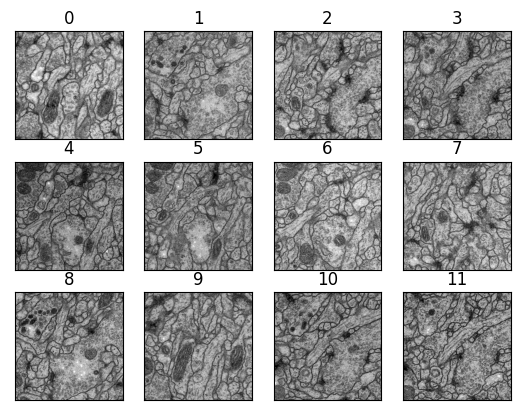

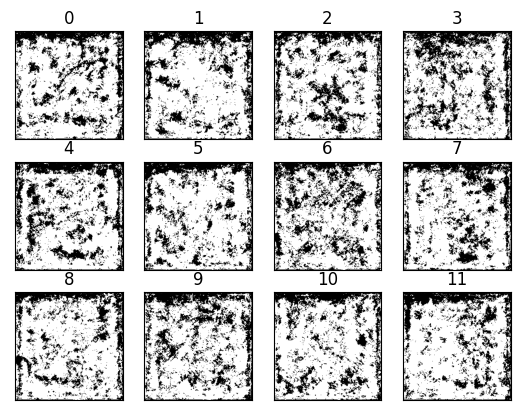

In [10]:
image_path = "ISBI/test/image/"
pred_path = "predict/"

image_list = os.listdir(image_path)#读取测试图像
pred_list = os.listdir(pred_path)[1:]#读取预测结果
# print(image_list)
# print(pred_list)
#读取图像文件
test_image = np.array([cv2.imread(image_path + image_list[p], -1) for p in range(len(image_list))])
pred_masks = np.array([cv2.imread(pred_path + pred_list[p], -1) for p in range(len(pred_list))])
#显示测试图像和预测结果。num参数表示要显示的图像数量
show_image(test_image, num = 12)
show_image(pred_masks, num = 12)